# Multi-Parameter Example

This notebook demonstrates a more complex version of the [sine wave problem](SineWave.ipynb) with all three parameters floating. It introduces some helper functions for defining prior probability densities and a "corner plot" to visualize multi-dimensional prior and posterior probability densities.

In [1]:
try:
    import bed
except ImportError:
    %pip install bayesdesign

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from bed.grid import Grid, GridStack, TopHat, CosineBump
from bed.design import ExperimentDesigner
from bed.plot import cornerPlot

Define the design and feature grids, similar to how we did [previously](SineWave.ipynb) but with fewer grid points, to control the total memory required after expanding the parameter grid.

In [4]:
designs = Grid(t_obs=np.linspace(0, 4, 64))
features = Grid(y_obs=np.linspace(-1.4, 1.4, 80))

Define the parameter grid with all three parameters allowed to vary:

In [5]:
params = Grid(amplitude=np.linspace(0.8, 1.2, 50), frequency=np.linspace(0.2, 2.0, 50), offset=np.linspace(-0.5, 0.5, 50))

Define the likelihood. This code is identical to what we used [previously](SineWave.ipynb) since it is written to be independent of which parameters are floating or fixed.

In [6]:
sigma_y=0.1
with GridStack(features, designs, params):
    y_mean = params.amplitude * np.sin(params.frequency * (designs.t_obs - params.offset))
    y_diff = features.y_obs - y_mean
    likelihood = np.exp(-0.5 * (y_diff / sigma_y) ** 2)
    features.normalize(likelihood)

Initialize the experiment designer:

In [7]:
designer = ExperimentDesigner(params, features, designs, likelihood)

Next we need to define our prior over the three parameters. Since a single measurement is not able to significantly constrain the allowed values of the amplitude or phase, we impose a centrally peaked prior on these parameters. We often use a Gaussian prior in cases like this, but is not a good match to the finite extent of each parameter in our grid, which would truncate the Gaussian. Instead, we use a scaled cosine function which goes to zero at its edges. We keep a flat or "top hat" prior on the frequency. Putting these pieces together looks like this:

In [8]:
prior = TopHat(params.frequency) * CosineBump(params.amplitude) * CosineBump(params.offset)

We do not need to explicitly normalize a prior constructed with these helper functions:

In [9]:
assert np.allclose(params.sum(prior), 1)

A "corner plot" is a useful way to visualize a probability density over multiple variables simultaneously and is provided via `plot.cornerPlot`:

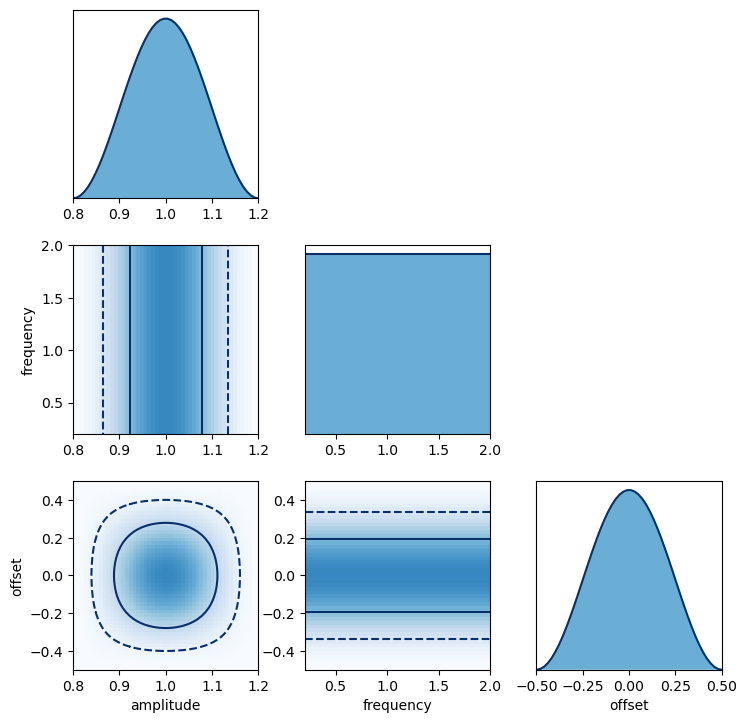

In [10]:
cornerPlot(prior, params);

Next, use this prior to calculate the expected information gain (EIG) on all three parameters simulatenously, over the design space. This code is also identical to what we used before.

In [11]:
best = designer.calculateEIG(prior)
designer.describe()

GRID       designs [64:t_obs]
GRID      features [80:y_obs]
GRID    parameters [50:amplitude, 50:frequency, 50:offset]
ARRAY        prior (50, 50, 50)               1.0 Mb
ARRAY   likelihood (80, 64, 50, 50, 50)    4882.8 Mb
ARRAY    posterior (80, 64, 50, 50, 50)    4882.8 Mb
ARRAY     marginal (80, 64)                   0.0 Mb
ARRAY           IG (80, 64)                   0.0 Mb
ARRAY          EIG (64,)                      0.0 Mb


Finally, let's make a measurement using the best design and assume we obtain $y_{obs} = -0.5$. Use the `designer` to extract the resulting posterior probability density on our three parameters:

In [12]:
post = designer.get_posterior(t_obs=best['t_obs'], y_obs=-0.5)

Plot this posterior and compare with the prior plotted above:

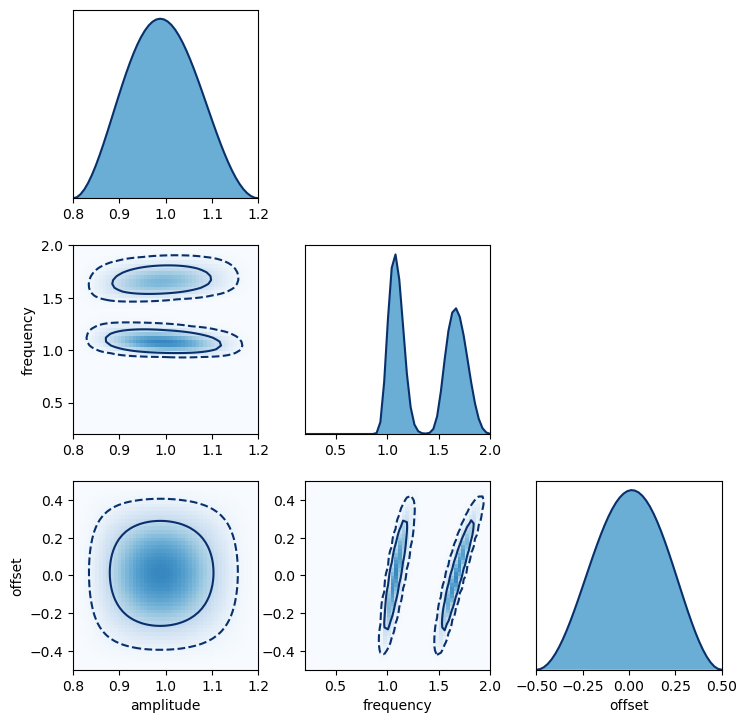

In [13]:
cornerPlot(post, params);